In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
donors_csv = f"./output/donors_with_recip_pacs_all_years_trunc.csv"

In [3]:
all_donors = pd.read_csv(donors_csv)
all_donors.head(10)

,Unnamed: 0,contrib_id,recip_id,name_new,gender,occupation,city,state,total_donated,sector,...,cmte_id,pac_short,affiliate,recip_id_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,cycle
0,0,U00000037041,N00029349,michael r bloomberg,M,FOUNDER,NEW YORK,NY,1.086565e+09,Party,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
1,1,U00000036521,N00044966,tom steyer,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.179460e+08,Party,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
2,2,,N00001669,information information requested,,NaN,NEW YORK,CA,9.947018e+07,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
3,3,,C00484642,majority forward majority forward,,NaN,WASHINGTON,DC,9.866908e+07,Party,...,C00484642,Senate Majority PAC,Senate Majority PAC,C00484642,NaN,,True,1.0,Unknown,2020
4,4,,C00618371,winred winred,,NaN,ARLINGTON,VA,9.195982e+07,Party,...,C00618371,Trump Make America Great Again Cmte,NaN,C00618371,NaN,R,True,0.0,Unknown,2020
5,5,,C00571703,koch industries inc koch industries inc,,NaN,WASHINGTON,TX,6.460129e+07,Unknown,...,C00571703,Senate Leadership Fund,Senate Leadership Fund,C00571703,NaN,,True,0.0,Unknown,2020
6,6,,C00495028,chc bold pac chc bold pac,,NaN,WASHINGTON,DC,5.408387e+07,Party,...,C00495028,House Majority PAC,House Majority PAC,C00495028,NaN,NaN,True,NaN,Unknown,2020
7,7,,C00693382,fund for policy reform fund for policy reform,,NaN,WILMINGTON,DE,4.950000e+07,Ideology/Single Issue,...,C00693382,Democracy PAC ...,NaN,C00693382,NaN,NaN,True,NaN,Unknown,2020
8,8,,C00669259,future forward usa action future forward usa a...,,NaN,WASHINGTON,DC,4.526326e+07,Ideology/Single Issue,...,C00669259,Future Forward USA,NaN,C00669259,NaN,,True,1.0,Unknown,2020
9,9,,C00504530,american action network american action network,,NaN,WASHINGTON,DC,4.465169e+07,Party,...,C00504530,Congressional Leadership Fund,Congressional Leadership Fund,C00504530,NaN,NaN,True,NaN,Unknown,2020


In [4]:
all_donors.columns

Index(['Unnamed: 0', 'contrib_id', 'recip_id', 'name_new', 'gender',
       'occupation', 'city', 'state', 'total_donated', 'sector', 'ethnic',
       'name_y', 'party', 'seat', 'type', 'cmte_id', 'pac_short', 'affiliate',
       'recip_id_pac', 'cand_id', 'party_pac', 'recip_is_pac', 'dem_ratio',
       'level', 'cycle'],
      dtype='object')

In [50]:
def identify_top_donors(group):
    top_donors = (group.groupby('contrib_id')['total_donated']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10000)
                 .index)
    
    group = group.copy()
    group.loc[:, 'donor_type'] = group['contrib_id'].isin(top_donors).map({
        True: 'Top 10,000 Donors',
        False: 'Other Donors'
    })
    return group

temp = (all_donors.groupby('cycle', group_keys=False)
              .apply(identify_top_donors)
              .reset_index(drop=True))
cycle_donations = (temp.groupby(['cycle', 'donor_type'])['total_donated']
                  .sum()
                  .unstack())
cycle_percentages = cycle_donations.div(cycle_donations.sum(axis=1), axis=0) * 100

KeyboardInterrupt: 

<Figure size 1400x400 with 0 Axes>

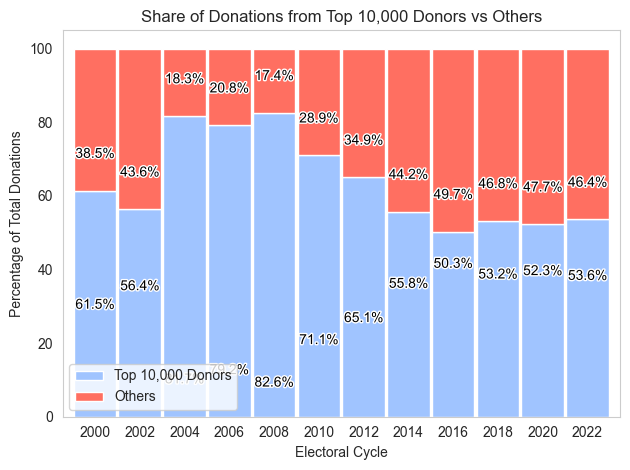

In [ ]:
plt.figure(figsize=(14, 4))
sns.set_style("whitegrid")

cycle_percentages.plot(kind='bar', stacked=True, color=['#A0C4FF', '#FF6F61'], width=0.95)

plt.title('Share of Donations from Top 10,000 Donors vs Others')
plt.ylabel('Percentage of Total Donations')
plt.xlabel('Electoral Cycle')
plt.xticks(rotation=0)

for n, cycle in enumerate(cycle_percentages.index):
    top_pct = cycle_percentages.loc[cycle, 'top_donor']
    other_pct = cycle_percentages.loc[cycle, 'other_donor']

    plt.text(n, other_pct + 10, f'{top_pct:.1f}%', ha='center', va='center', fontsize=10, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])
    plt.text(n, top_pct - 10, f'{other_pct:.1f}%', ha='center', va='bottom', fontsize=10, color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

plt.grid(False)
plt.legend(['Top 10,000 Donors', 'Others'], loc='lower left', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
cycle_percentages

NameError: name 'cycle_percentages' is not defined

In [ ]:
cycle_donations

donor_type,other_donor,top_donor
cycle,,
2000,1.135718e+09,7.121755e+08
2002,8.753118e+08,6.763623e+08
2004,1.855189e+09,4.146190e+08
2006,1.323453e+09,3.469266e+08
2008,2.794978e+09,5.880164e+08
2010,1.439983e+09,5.864548e+08
2012,3.173984e+09,1.703377e+09
2014,1.532654e+09,1.215793e+09
2016,3.397436e+09,3.352805e+09


In [ ]:
cycle_counts

donor_type,other_donor,top_donor
cycle,,
2000,776562,4171
2002,650628,4199
2004,1123641,6088
2006,773202,6481
2008,1344731,7734
2010,812281,7666
2012,1268410,8204
2014,733185,7938
2016,2427625,8515


In [5]:
pres_donors = all_donors[all_donors["level"] == "President"]
pres_donors

,Unnamed: 0,contrib_id,recip_id,name_new,gender,occupation,city,state,total_donated,sector,...,cmte_id,pac_short,affiliate,recip_id_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,cycle
0,0,U00000037041,N00029349,michael r bloomberg,M,FOUNDER,NEW YORK,NY,1.086565e+09,Party,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
1,1,U00000036521,N00044966,tom steyer,M,PRESIDENTIAL CANDIDATE,SAN FRANCISCO,CA,3.179460e+08,Party,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
2,2,,N00001669,information information requested,,NaN,NEW YORK,CA,9.947018e+07,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
12,12,,N00023864,ion republ puiu,,NaN,KEW GARDENS,CA,3.708834e+07,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,President,2020
267,267,c00401783831,N00033897,john kevin delaney,M,PRESIDENTIAL CANDIDATE,POTOMAC,MD,1.089075e+06,Party,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549087,32549087,r0000583332,N00001669,ilene schwerin,F,NOT EMPLOYED,NOVATO,CA,1.000000e+00,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2022
32549185,32549185,q0002672990,N00001669,adrienne gottlieb,F,NOT EMPLOYED,SOLON,OH,1.000000e+00,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2022
32549213,32549213,r0003559846,N00001669,paige godden,F,REPORTER,PANORA,IA,1.000000e+00,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2022
32549214,32549214,q0002813017,N00001669,charles manus,M,TELECOMMUNICATIONS,N BETHESDA,MD,1.000000e+00,Tech,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2022


In [6]:
pres_donors[(pres_donors["ethnic"] == "ind") & (pres_donors["party"].isin(["D", "R"])) & (pres_donors["cycle"] % 4 == 0)].groupby(["cycle", "name_y"])["total_donated"].sum().iloc[-40:-30]

cycle  name_y             
2012   Rick Santorum (R)         9001.0
       Ron Paul (R)             63369.0
       Tim Pawlenty (R)         36000.0
2016   Barack Obama (D)         37855.0
       Ben Carson (R)           42355.0
       Bobby Jindal (R)         46500.0
       Carly Fiorina (R)        20150.0
       Chris Christie (R)       99100.0
       Donald Trump (R)        396945.0
       Hillary Clinton (D)    4710287.0
Name: total_donated, dtype: float64

In [14]:
all_donors[(all_donors["sector"] == "Finance") & (all_donors["cycle"] == 2000) & (all_donors["ethnic"] == "ind")].groupby(["name_new"])["total_donated"].sum().sort_values(ascending=False).iloc[:20]

name_new
e s p das                45000.0
sunil puri               44000.0
reed l harman            43600.0
kanwal mr rekhi          30000.0
saeed ullah khan         28000.0
vinod khosla             25000.0
kanwal rekhi             23000.0
rajh singh               20000.0
hema s khan              14500.0
shahnaz s khan           12500.0
peter k shah             11100.0
purnendu chatterjee      11000.0
pratap v rajadhyaksha    10000.0
shahnaz khan             10000.0
khalid khan              10000.0
hema khan                 8000.0
pritam singh              7000.0
muneer a satter           6750.0
shekar narasimhan         6500.0
vikram s pandit           6000.0
Name: total_donated, dtype: float64

In [12]:
all_donors[(all_donors["sector"] == "Finance") & (all_donors["cycle"] == 2000) & (all_donors["ethnic"] == "ind")].groupby(["name_new", "party"])["total_donated"].sum().sort_values(ascending=False).iloc[:20]

name_new               party
reed l harman          R        23600.0
saeed ullah khan       D        23000.0
kanwal rekhi           D        20500.0
vinod khosla           R        20000.0
e s p das              D        20000.0
rajh singh             D        20000.0
sunil puri             D        17000.0
purnendu chatterjee    D        11000.0
pratap v rajadhyaksha  D        10000.0
hema khan              D         8000.0
saroj kalra            D         6000.0
peter k shah           D         5600.0
khalid khan            D         5000.0
saeed khan             D         5000.0
vipool m patel         D         5000.0
laila khan             D         5000.0
shahnaz khan           D         5000.0
vinod k kalra          D         5000.0
shailesh mehta         D         4000.0
vikram s pandit        R         4000.0
Name: total_donated, dtype: float64

In [ ]:
all_donors[all_donors["name_new"] == "vinod khosla"].groupby(["cycle", "party"])["total_donated"].sum()

party,D,I,R
cycle,,,
2000,NaN,NaN,20000.0
2002,2000.0,NaN,NaN
2004,31000.0,NaN,NaN
2006,73800.0,NaN,5100.0
2008,112100.0,NaN,1000.0
2010,113500.0,2400.0,NaN
2012,113800.0,NaN,15000.0
2014,122700.0,NaN,5200.0
2016,70800.0,NaN,NaN


In [16]:
all_donors[all_donors["name_new"] == "vinod khosla"].groupby(["cycle", "party_pac"])["total_donated"].sum()

cycle  party_pac
2000   R              20000.0
2004   D              23000.0
2006   D              59400.0
2008   D              62000.0
2010   D              77500.0
2012   D              75800.0
2014   D              94500.0
2016   D              52000.0
2020                1100000.0
       D             312499.0
2022                1000000.0
       D             537200.0
Name: total_donated, dtype: float64

In [8]:
all_donors[(all_donors["sector"] == "Finance") & (all_donors["cycle"] == 2000) & (all_donors["ethnic"] == "ind")].groupby(["name_new", "party_pac"])["total_donated"].sum().sort_values(ascending=False).iloc[:10]

name_new               party_pac
reed l harman          R            20600.0
vinod khosla           R            20000.0
saeed ullah khan       D            20000.0
kanwal rekhi           D            20000.0
e s p das              D            20000.0
rajh singh             D            20000.0
sunil puri             D            15000.0
purnendu chatterjee    D            10000.0
pratap v rajadhyaksha  D            10000.0
saeed khan             D             5000.0
Name: total_donated, dtype: float64

In [17]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["cycle"] == 2000)].groupby(["cycle", "sector"])["total_donated"].sum().sort_index()

cycle  sector               
2000   Agribusiness               24574.0
       Construction              300567.0
       Defense                    19700.0
       Energy                    181654.0
       Finance                   856579.0
       Health                   1337349.0
       Ideology/Single Issue     135545.0
       Labor                       3613.0
       Law                       115572.0
       Manufacturing             122850.0
       Party                       6000.0
       Tech                      797789.0
       Transportation            199570.0
       Unknown                  1072805.0
Name: total_donated, dtype: float64

In [18]:
all_donors[(all_donors["ethnic"] == "ind")].groupby(["cycle"])["total_donated"].sum().sort_index()

cycle
2000     6025212.0
2002     4180650.0
2004    11288322.0
2006     9109669.0
2008    19286314.0
2010    11235809.0
2012    26220575.0
2014    15488981.0
2016    48025092.0
2018    44131535.0
2020    80911468.0
2022    69612530.0
Name: total_donated, dtype: float64

In [13]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["cycle"] == 2020)].groupby(["cycle", "sector"])["total_donated"].sum().sort_index()

cycle  sector               
2020   Agribusiness               298699.0
       Construction              1017303.0
       Defense                    576426.0
       Energy                     489489.0
       Finance                  16630991.0
       Health                   11385300.0
       Ideology/Single Issue     3489078.0
       Labor                       67090.0
       Law                       1833966.0
       Manufacturing             1521314.0
       Party                    22551869.0
       Tech                      4673204.0
       Transportation            1819022.0
       Unknown                   8863553.0
Name: total_donated, dtype: float64

In [5]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors["state"].isin(["NY", "NJ"]))]

,Unnamed: 0,contrib_id,recip_id,name_new,gender,occupation,city,state,total_donated,sector,...,cmte_id,pac_short,affiliate,recip_id_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,cycle
1825,1825,U0000004554,C00484642,vivek garipalli,M,CEO,COLTS NECK,NJ,250000.0,Finance,...,C00484642,Senate Majority PAC,Senate Majority PAC,C00484642,NaN,,True,1.000000,Unknown,2020
2421,2421,k00011306811,C00744946,bharat bhise,M,CEO,NEW YORK,NY,200000.0,Party,...,C00744946,Biden Victory Fund,NaN,C00744946,NaN,D,True,0.967915,Unknown,2020
3084,3084,q0001021232,C00010603,tushar shah,M,INFORMATION REQUESTED,BRONXVILLE,NY,147200.0,Finance,...,C00010603,DNC Services Corp,Democratic National Cmte,C00010603,NaN,D,True,1.000000,Unknown,2020
3648,3648,j10012097301,C00744946,girish reddy,M,MANAGING PARTNER,SUMMIT,NJ,125000.0,Finance,...,C00744946,Biden Victory Fund,NaN,C00744946,NaN,D,True,1.000000,Unknown,2020
3960,3960,g11006621431,C00744946,parag saxena,M,CEO,NEW YORK,NY,110000.0,Finance,...,C00744946,Biden Victory Fund,NaN,C00744946,NaN,D,True,1.000000,Unknown,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32543779,32543779,s0013681043,C00401224,surjeet gupta,F,NaN,NY,NY,1.0,Party,...,C00401224,ActBlue,NaN,C00401224,NaN,NaN,True,1.000000,Unknown,2022
32545946,32545946,r0017776314,C00401224,babul chowdhury,M,NaN,OZONE PARK,NY,1.0,Party,...,C00401224,ActBlue,NaN,C00401224,NaN,NaN,True,NaN,Unknown,2022
32547720,32547720,q0002006606,C00003418,narendra bisht,M,SALES,WOODSIDE,NY,1.0,Unknown,...,C00003418,Republican National Cmte,Republican National Cmte,C00003418,NaN,R,True,0.000000,Unknown,2022
32548421,32548421,r0015069495,C00401224,ferdous khan,F,NaN,COLLEGEPOINT,NY,1.0,Party,...,C00401224,ActBlue,NaN,C00401224,NaN,NaN,True,1.000000,Unknown,2022


In [10]:
all_donors[all_donors["name_new"].str.contains("narasimhan", na=False)]

,Unnamed: 0,contrib_id,recip_id,name_new,gender,occupation,city,state,total_donated,sector,...,cmte_id,pac_short,affiliate,recip_id_pac,cand_id,party_pac,recip_is_pac,dem_ratio,level,cycle
5949,5949,c0140372601,C00010603,shekar n narasimhan,M,MANAGING PARTNER,DUNN LORING,VA,88410.0,Finance,...,C00010603,DNC Services Corp,Democratic National Cmte,C00010603,NaN,D,True,1.0,Unknown,2020
6306,6306,c0140372601,C00589507,shekar narasimhan,M,MANAGING PARTNER,DUNN LORING,VA,80000.0,Ideology/Single Issue,...,C00589507,AAPI Victory Fund,NaN,C00589507,NaN,,True,1.0,Unknown,2020
8565,8565,b00607754321,C00697755,shekar narasimhan,M,PARTNER,MC LEAN,VA,55000.0,Finance,...,C00697755,Virginia Plus PAC,NaN,C00697755,NaN,,True,1.0,Unknown,2020
15127,15127,c0140372601,C00492421,shekar narasimhan,M,PARTNER,DUNN LORING,VA,35500.0,Finance,...,C00492421,Nancy Pelosi Victory Fund,NaN,C00492421,H8CA05035,D,True,1.0,Unknown,2020
19578,19578,c0140372601,C00000935,shekar narasimhan,M,PARTNER,DUNN LORING,VA,29900.0,Finance,...,C00000935,Democratic Congressional Campaign Cmte,Democratic Congressional Campaign Cmte,C00000935,NaN,D,True,1.0,Unknown,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31717755,31717755,p0005256459,C00227546,rangaprasad narasimhan,U,PRINCIPAL SOFTWARE ENG MANAGER,REDMOND,WA,80.0,Tech,...,C00227546,Microsoft Corp,NaN,C00227546,NaN,NaN,True,NaN,Unknown,2022
31723624,31723624,s0006277159,C00004036,narasimhan shankar,M,HOME HEALTHCARE,SUNNYVALE,CA,80.0,Labor,...,C00004036,Service Employees International Union,Service Employees International Union,C00004036,NaN,NaN,True,NaN,Unknown,2022
31841413,31841413,p0001310764,C00762591,narasimhan s jagannathan,U,RETIRED,CHARLOTTE,NC,66.0,NaN,...,C00762591,Save America,President Donald J Trump,C00762591,NaN,R,True,0.0,Unknown,2022
32286125,32286125,r0013266721,N00001669,sumana narasimhan,F,PHYSICIAN,MASSILLON,OH,25.0,Health,...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.0,President,2022


In [7]:
agg_all = all_donors.groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_all['group'] = 'All Donors'
agg_indian = all_donors[all_donors['ethnic'] == 'ind'].groupby('cycle')['total_donated'].agg(['mean', 'median']).reset_index()
agg_indian['group'] = 'Indian-American Donors'

combined = pd.concat([agg_all, agg_indian])

In [29]:
all_donors[all_donors["name_new"] == "prem reddy"].groupby("cycle")["total_donated"].sum()

cycle
2000      31500.0
2002       8000.0
2004      20523.0
2006      12400.0
2008      41400.0
2010      52100.0
2012      93481.0
2014      75100.0
2016      38050.0
2018      40450.0
2020    1262200.0
2022    1086649.0
Name: total_donated, dtype: float64

In [31]:
all_donors[(all_donors["sector"] == "Health") & (all_donors["ethnic"] == "ind")].groupby(["cycle", "name_new"])["total_donated"].sum().sort_values(ascending=False).iloc[:20]

cycle  name_new                    
2020   ramalinga mantena               1180000.0
2022   prem reddy                      1080849.0
2016   vivek garipalli                 1058500.0
       rishi u shah                    1048300.0
2020   padmaja mrs mantena              959400.0
       sivakami sambasivam              614064.0
2016   willa rao                        611870.0
2020   prem reddy                       530900.0
2012   griff harsh                      450000.0
2020   nirmal mulye                     416999.0
2022   raj mantena                      340300.0
2016   ijaz ahmad                       310434.0
       shradha agarwal                  303212.0
2020   kavitha bhatia                   252212.0
       padmaja mantena                  241800.0
2016   griffith rutherford iv harsh     236500.0
2022   jill singh                       218524.0
       gunjan jain                      197900.0
2018   willa rao                        182600.0
2020   jill singh                

In [33]:
all_donors[(all_donors["name_new"] == "sivakami sambasivam")].groupby("cycle")["total_donated"].sum()

cycle
2020    710763.0
2022     66300.0
Name: total_donated, dtype: float64

In [20]:
mean_all = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle", "sector"])["dem_ratio"].mean().sort_values(ascending=False)
mean_all = mean_all.unstack(level='sector')
mean_ind = mean_ind.unstack(level='sector')

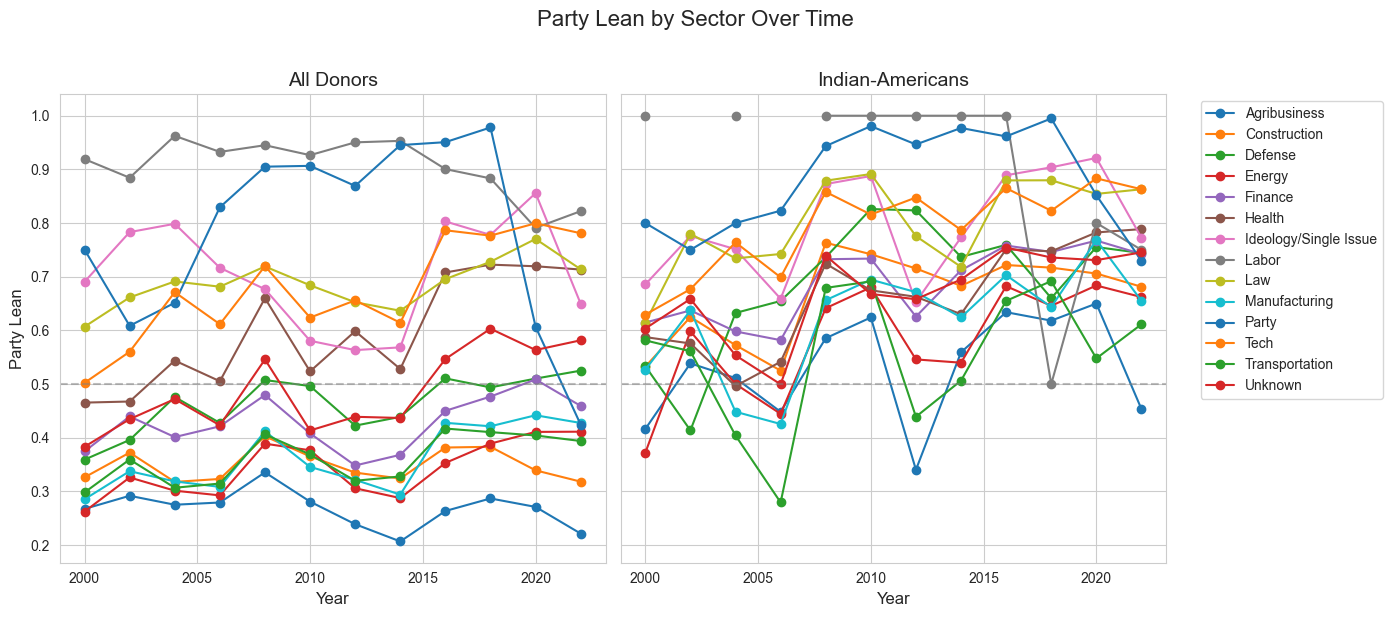

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in mean_all.columns:
    ax1.plot(
        mean_all.index,
        mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in mean_ind.columns:
    ax2.plot(
        mean_ind.index,
        mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [22]:
mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.267316,0.326098,0.359120,0.262300,0.374497,0.465375,0.690557,0.919090,0.606807,0.285300,0.750420,0.502188,0.297993,0.383134
2002,0.291728,0.372199,0.395771,0.325875,0.439570,0.467410,0.783091,0.884434,0.661377,0.337569,0.608454,0.560163,0.359343,0.434498
2004,0.275064,0.317615,0.475845,0.301248,0.401163,0.543730,0.798594,0.962507,0.691146,0.318560,0.651382,0.671183,0.306730,0.471947
2006,0.279201,0.323120,0.427470,0.292525,0.421176,0.505205,0.716642,0.932556,0.681370,0.308302,0.829388,0.611473,0.314558,0.423063
2008,0.335351,0.402614,0.507415,0.388819,0.479447,0.659899,0.676727,0.945012,0.719034,0.411786,0.905035,0.719779,0.406104,0.545791
2010,0.280847,0.365162,0.496238,0.376539,0.407894,0.523569,0.580569,0.926508,0.684016,0.345512,0.906570,0.623825,0.368701,0.413478
2012,0.238802,0.334915,0.422433,0.305744,0.348197,0.598430,0.563202,0.950358,0.652383,0.321422,0.869165,0.655892,0.319707,0.438942
2014,0.206665,0.323948,0.438797,0.287493,0.368086,0.528000,0.568298,0.953109,0.636574,0.293903,0.945248,0.614196,0.327750,0.436743
2016,0.263377,0.381677,0.510529,0.352921,0.450046,0.707863,0.802999,0.900527,0.695425,0.427699,0.950711,0.786496,0.417042,0.546617


In [23]:
mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.416149,0.532243,0.533333,0.371873,0.614564,0.587456,0.685532,1.00,0.614380,0.526679,0.800000,0.629376,0.581340,0.603409
2002,0.538462,0.624891,0.413636,0.598039,0.637151,0.575587,0.775865,NaN,0.779924,0.637118,0.750000,0.676722,0.561075,0.658518
2004,0.511111,0.572449,0.632456,0.500000,0.597997,0.496240,0.751159,1.00,0.734127,0.448306,0.800000,0.763917,0.404094,0.553458
2006,0.448214,0.524989,0.654762,0.444444,0.581754,0.541433,0.658914,NaN,0.742308,0.425488,0.823010,0.698813,0.279328,0.499505
2008,0.585366,0.763292,0.736144,0.641304,0.732536,0.724229,0.872656,1.00,0.878886,0.656235,0.943396,0.857982,0.679112,0.739088
2010,0.624000,0.741855,0.826087,0.680123,0.733739,0.674602,0.887588,1.00,0.891335,0.694553,0.980583,0.815844,0.691232,0.667833
2012,0.340202,0.715313,0.823529,0.545844,0.625625,0.662514,0.652736,1.00,0.775578,0.671204,0.946435,0.847527,0.438991,0.658029
2014,0.559250,0.682892,0.736842,0.539760,0.711980,0.630132,0.773208,1.00,0.718290,0.624225,0.977120,0.787012,0.506354,0.694726
2016,0.633880,0.721729,0.759334,0.682295,0.758058,0.751187,0.889046,1.00,0.879446,0.702880,0.961404,0.865021,0.655004,0.754254


In [24]:
dollar_mean_all = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)
dollar_mean_ind = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle", "sector"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
    .unstack(level='sector')
)

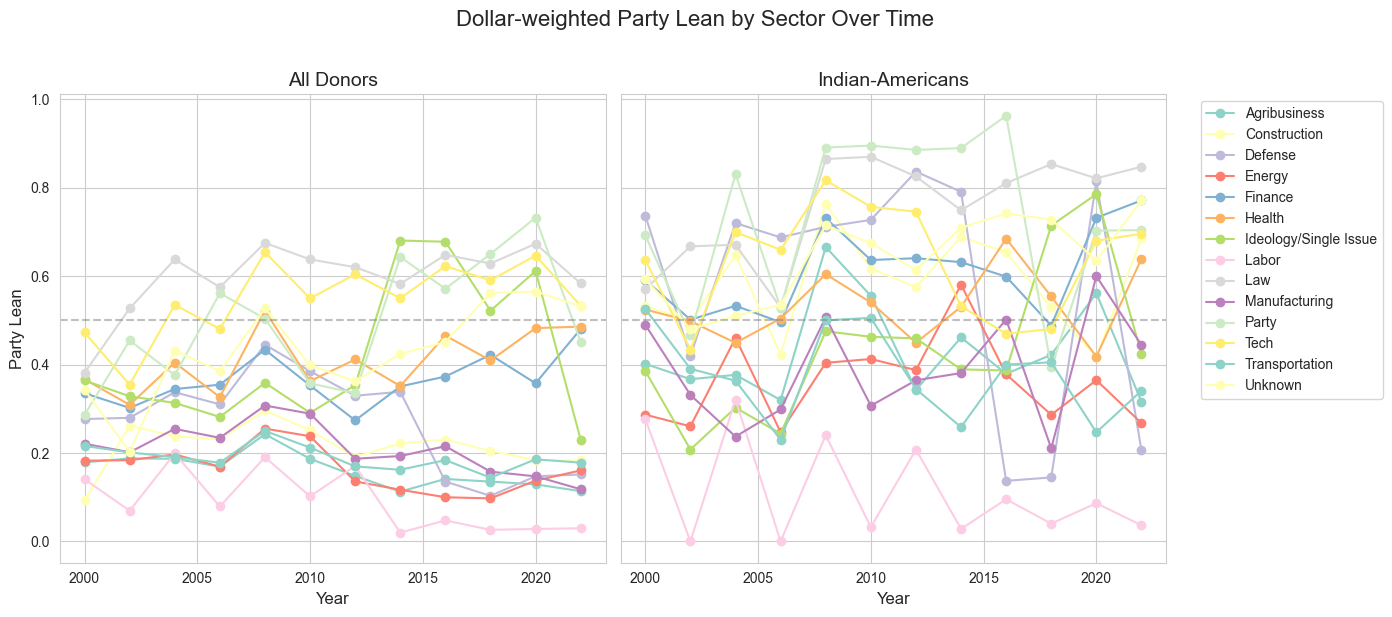

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")
sns.set_palette("Set3", n_colors=len(mean_all.columns))

for sector in dollar_mean_all.columns:
    ax1.plot(
        dollar_mean_all.index,
        dollar_mean_all[sector],
        marker='o',
        label=sector
    )
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

for sector in dollar_mean_ind.columns:
    ax2.plot(
        dollar_mean_ind.index,
        dollar_mean_ind[sector],
        marker='o',
        label=sector
    )
ax2.set_title('Indian-Americans', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Dollar-weighted Party Lean by Sector Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [26]:
dollar_mean_all

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.178917,0.092835,0.276898,0.182672,0.335291,0.366939,0.364249,0.140773,0.381702,0.221068,0.286247,0.472823,0.216019,0.342847
2002,0.187897,0.261335,0.279675,0.183892,0.302100,0.309016,0.328384,0.069385,0.527044,0.201679,0.454719,0.354693,0.201366,0.202687
2004,0.186994,0.238496,0.337662,0.196818,0.344827,0.404486,0.313415,0.199051,0.638029,0.254729,0.376447,0.535230,0.190865,0.431579
2006,0.169091,0.230885,0.310045,0.169113,0.354560,0.326531,0.281676,0.079158,0.575190,0.234375,0.561649,0.480726,0.178019,0.385105
2008,0.242587,0.296258,0.445076,0.255284,0.433829,0.522184,0.358827,0.190558,0.675460,0.307516,0.504015,0.654353,0.250100,0.527434
2010,0.186936,0.251340,0.385185,0.238021,0.352836,0.362658,0.290902,0.102035,0.638098,0.289103,0.357502,0.549867,0.212274,0.398794
2012,0.148163,0.190648,0.329611,0.135813,0.273897,0.411621,0.353512,0.170618,0.620471,0.187033,0.335694,0.604354,0.169767,0.362628
2014,0.112777,0.221964,0.338601,0.116972,0.350634,0.351681,0.680792,0.019925,0.582687,0.193244,0.643504,0.550096,0.162137,0.424444
2016,0.141398,0.230612,0.135508,0.099931,0.373139,0.465692,0.678003,0.047544,0.648406,0.215446,0.571613,0.622913,0.184007,0.451217


In [27]:
dollar_mean_ind

sector,Agribusiness,Construction,Defense,Energy,Finance,Health,Ideology/Single Issue,Labor,Law,Manufacturing,Party,Tech,Transportation,Unknown
cycle,,,,,,,,,,,,,,
2000,0.401747,0.532400,0.737299,0.286772,0.591393,0.524596,0.385615,0.276778,0.571155,0.490063,0.692308,0.636775,0.525786,0.593787
2002,0.367031,0.498673,0.419952,0.260447,0.501657,0.498337,0.207972,0.000000,0.667654,0.331439,0.466667,0.434101,0.390546,0.480196
2004,0.376905,0.647590,0.720265,0.460535,0.533077,0.449272,0.302659,0.320718,0.671163,0.237161,0.831190,0.699772,0.363562,0.510615
2006,0.319842,0.422834,0.687806,0.247221,0.496077,0.504345,0.243905,0.000000,0.528917,0.298583,0.528421,0.659830,0.230017,0.535078
2008,0.666005,0.764289,0.711716,0.404089,0.731203,0.604599,0.475523,0.240298,0.865193,0.506898,0.891213,0.816974,0.500116,0.715016
2010,0.555635,0.617472,0.727508,0.412695,0.636719,0.540630,0.462980,0.032242,0.870284,0.306989,0.895579,0.757014,0.505897,0.674732
2012,0.342723,0.575544,0.836697,0.387596,0.640760,0.449766,0.459331,0.207994,0.825688,0.364569,0.885803,0.745926,0.344803,0.614157
2014,0.461601,0.689362,0.791100,0.580962,0.631871,0.530598,0.389300,0.028361,0.749268,0.380976,0.889966,0.532058,0.258603,0.709920
2016,0.379240,0.653809,0.137051,0.378197,0.599107,0.684996,0.386871,0.095334,0.810651,0.502095,0.963170,0.469834,0.400133,0.742139


In [28]:
mean_all_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["dem_ratio"].mean()
mean_ind_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[all_donors["ethnic"].str.contains("ind", na=False)].groupby(["cycle"])["dem_ratio"].mean()

In [44]:
mean_pres_by_year = (all_donors[all_donors['level'] == 'President']
                    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
                    .groupby(["cycle"])["dem_ratio"].mean())

mean_congress_by_year = (all_donors[all_donors['level'].isin(['House', 'Senate'])]
                        .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
                        .groupby(["cycle"])["dem_ratio"].mean())

mean_pres_ind_by_year = (all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')]
                    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
                    .groupby(["cycle"])["dem_ratio"].mean())

mean_congress_ind_by_year = (all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(['House', 'Senate']))]
                        .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
                        .groupby(["cycle"])["dem_ratio"].mean())

In [30]:
dollar_mean_all_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)
dollar_mean_ind_by_year = (
    all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    [all_donors["ethnic"].str.contains("ind", na=False)]
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [45]:
dollar_mean_pres_by_year = (
    all_donors[all_donors['level'] == 'President']
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_by_year = (
    all_donors[all_donors['level'].isin(['House', 'Senate'])]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_pres_ind_by_year = (
    all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_ind_by_year = (
    all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(['House', 'Senate']))]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [69]:
mean_all_men_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[(all_donors["gender"].isin(["M", "m"]))].groupby(["cycle"])["dem_ratio"].mean()
mean_all_women_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[(all_donors["gender"].isin(["F", "f"]))].groupby(["cycle"])["dem_ratio"].mean()
mean_ind_men_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[(all_donors["gender"].isin(["M", "m"])) & (all_donors["ethnic"].str.contains("ind", na=False))].groupby(["cycle"])["dem_ratio"].mean()
mean_ind_women_by_year = all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])[(all_donors["gender"].isin(["F", "f"])) & (all_donors["ethnic"].str.contains("ind", na=False))].groupby(["cycle"])["dem_ratio"].mean()

In [66]:
mean_pres_ind_by_year

cycle
2000    0.413344
2002    0.812500
2004    0.684404
2006    1.000000
2008    0.796989
2010    0.750000
2012    0.694008
2014    0.083333
2016    0.811110
2018    0.298315
2020    0.838669
2022    0.977735
Name: dem_ratio, dtype: float64

In [67]:
mean_congress_ind_by_year

cycle
2000    0.646295
2002    0.644073
2004    0.590853
2006    0.609219
2008    0.775214
2010    0.727257
2012    0.650749
2014    0.688847
2016    0.749320
2018    0.794819
2020    0.801998
2022    0.760617
Name: dem_ratio, dtype: float64

In [64]:
dollar_mean_pres_ind_by_year

cycle
2000    0.392203
2002    0.865471
2004    0.616667
2006    0.795918
2008    0.720673
2010    0.750000
2012    0.614249
2014    0.082163
2016    0.829958
2018    0.592728
2020    0.777488
2022    0.923988
dtype: float64

In [65]:
dollar_mean_congress_ind_by_year

cycle
2000    0.654062
2002    0.654723
2004    0.610113
2006    0.610141
2008    0.805505
2010    0.723951
2012    0.668821
2014    0.708452
2016    0.742163
2018    0.591976
2020    0.723865
2022    0.812203
dtype: float64

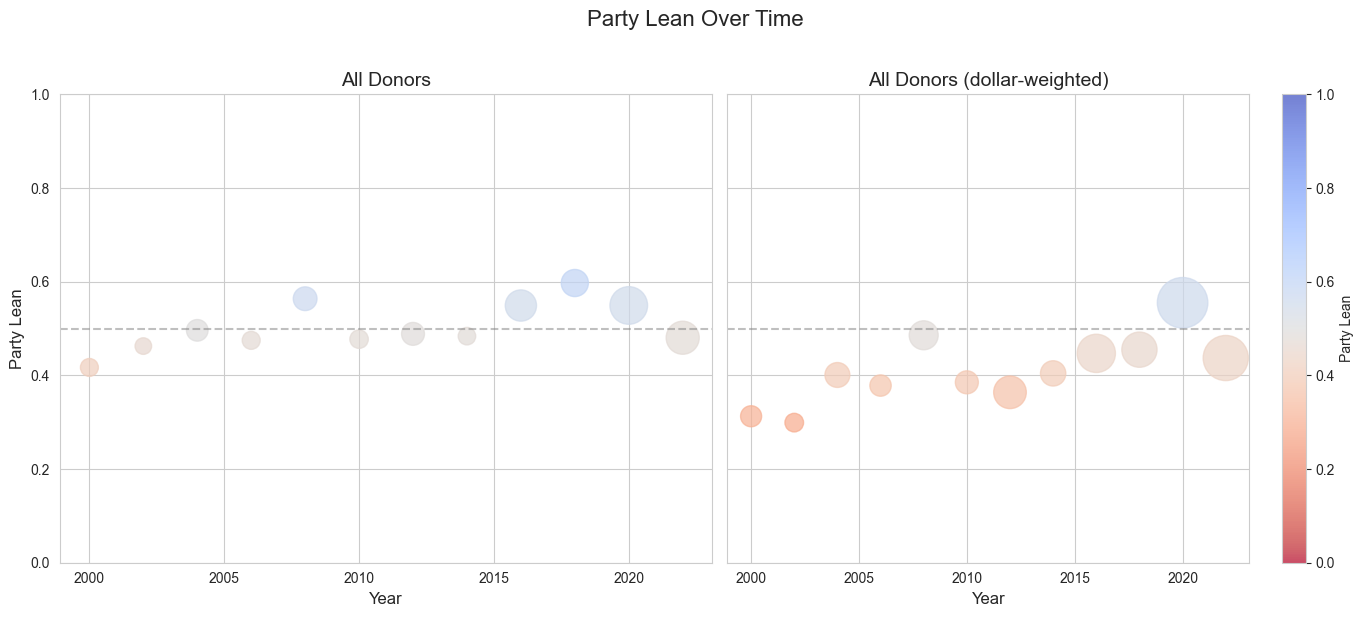

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all_by_year.index,
    mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/5000,
    c=mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all_by_year.index,
    dollar_mean_all_by_year,
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

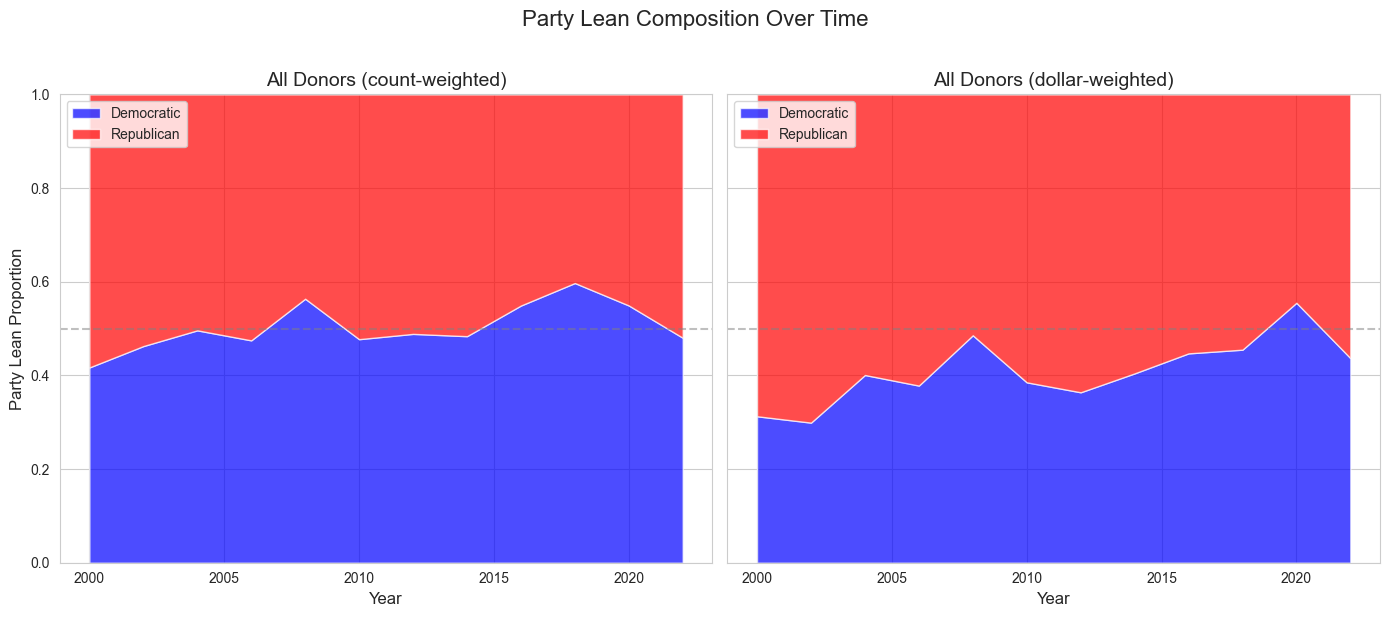

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.set_style("whitegrid")

# First subplot - Mean All (count-weighted)
plot_data1 = mean_all_by_year.to_frame(name='dem_ratio')
plot_data1['rep_ratio'] = 1 - plot_data1['dem_ratio']

ax1.stackplot(plot_data1.index, 
             plot_data1['dem_ratio'], 
             plot_data1['rep_ratio'],
             colors=['blue', 'red'],
             alpha=0.7,
             labels=['Democratic', 'Republican'])
ax1.set_title('All Donors (count-weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean Proportion', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(loc='upper left')

# Second subplot - Dollar Mean All (dollar-weighted)
plot_data2 = dollar_mean_all_by_year.to_frame(name='dem_ratio')
plot_data2['rep_ratio'] = 1 - plot_data2['dem_ratio']

ax2.stackplot(plot_data2.index, 
             plot_data2['dem_ratio'], 
             plot_data2['rep_ratio'],
             colors=['blue', 'red'],
             alpha=0.7,
             labels=['Democratic', 'Republican'])
ax2.set_title('All Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(loc='upper left')

plt.suptitle('Party Lean Composition Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

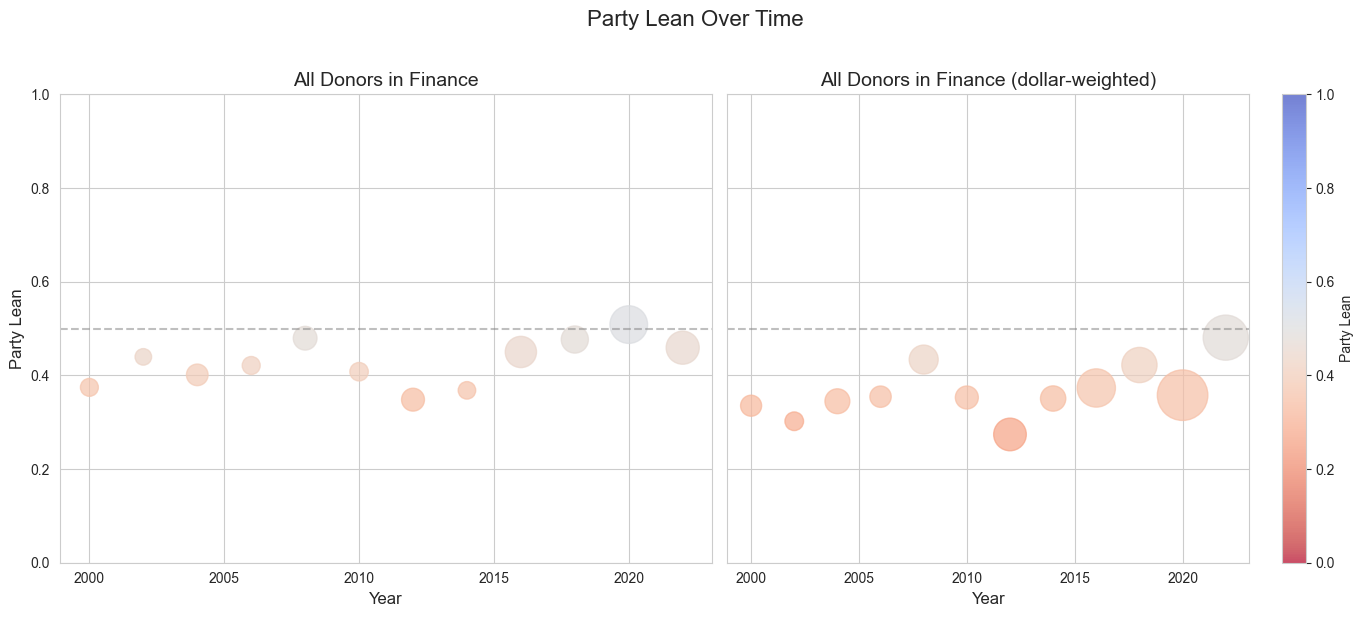

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_all.index,
    mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/5000,
    c=mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_all.index,
    dollar_mean_all["Finance"],
    s=all_donors.drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/5000000,
    c=dollar_mean_all["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

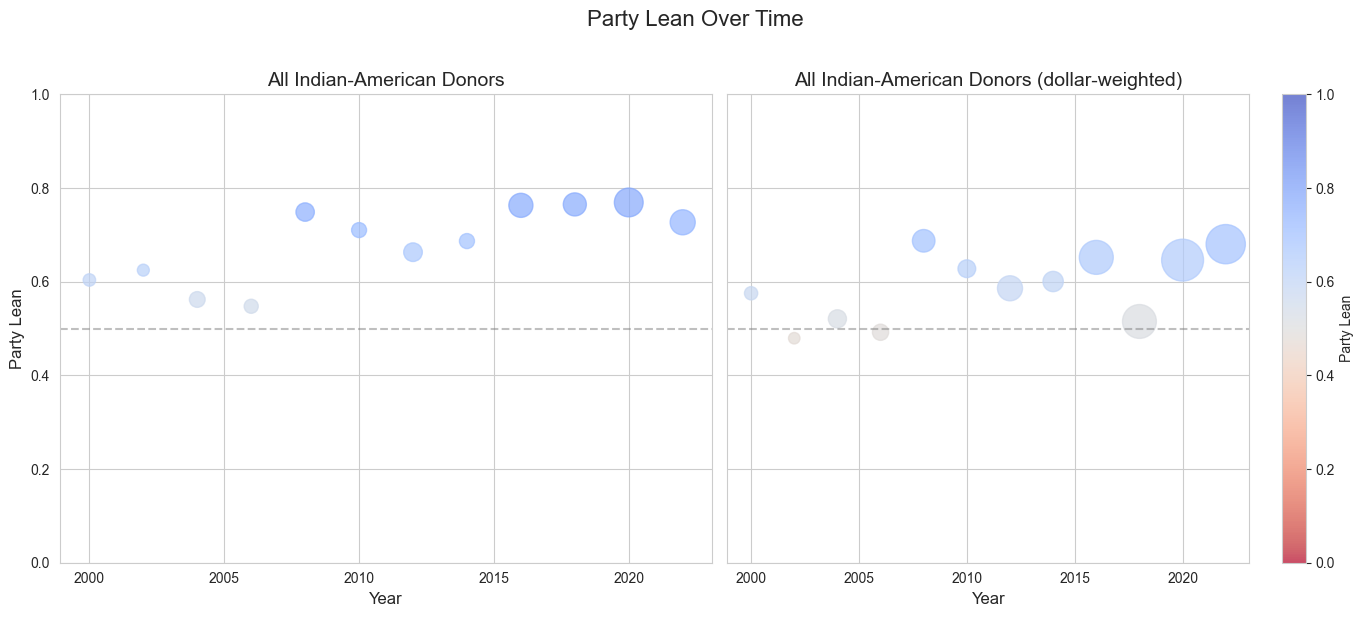

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind_by_year.index,
    mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind_by_year.index,
    dollar_mean_ind_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/50000,
    c=dollar_mean_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

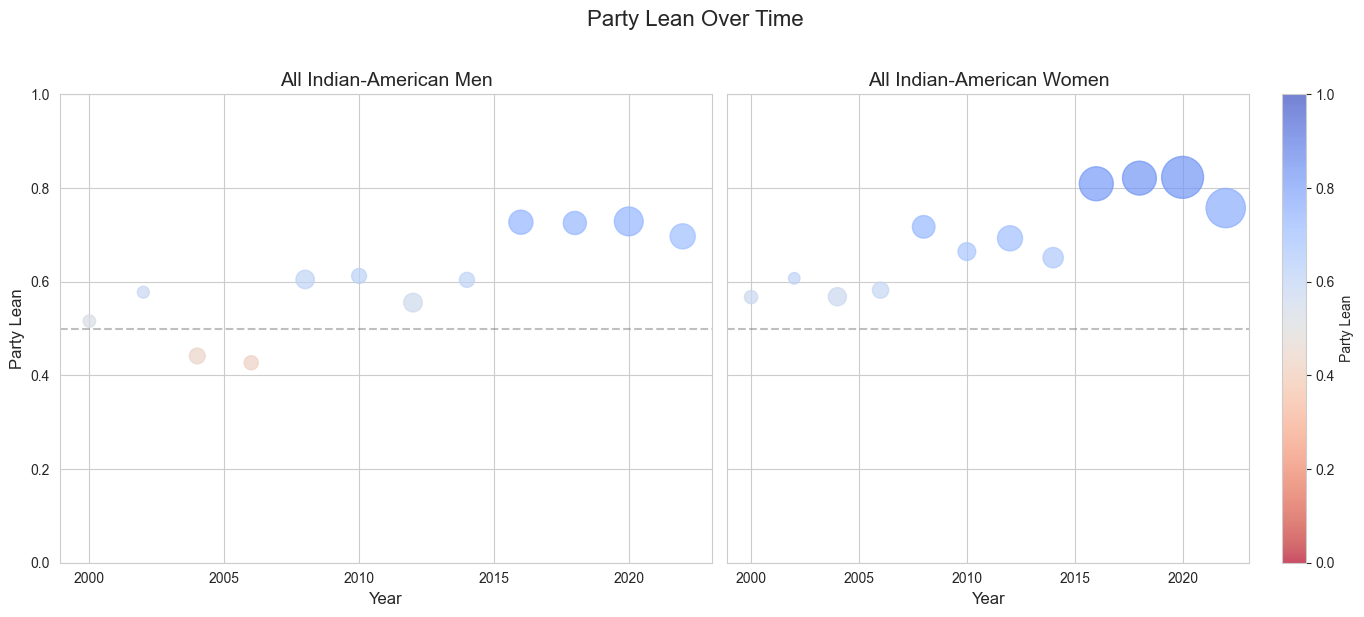

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind_men_by_year.index,
    mean_ind_men_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/50,
    c=mean_ind_men_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Men', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    mean_ind_women_by_year.index,
    mean_ind_women_by_year,
    s=all_donors[all_donors["ethnic"] == "ind"].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/50000,
    c=mean_ind_women_by_year,
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Women', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

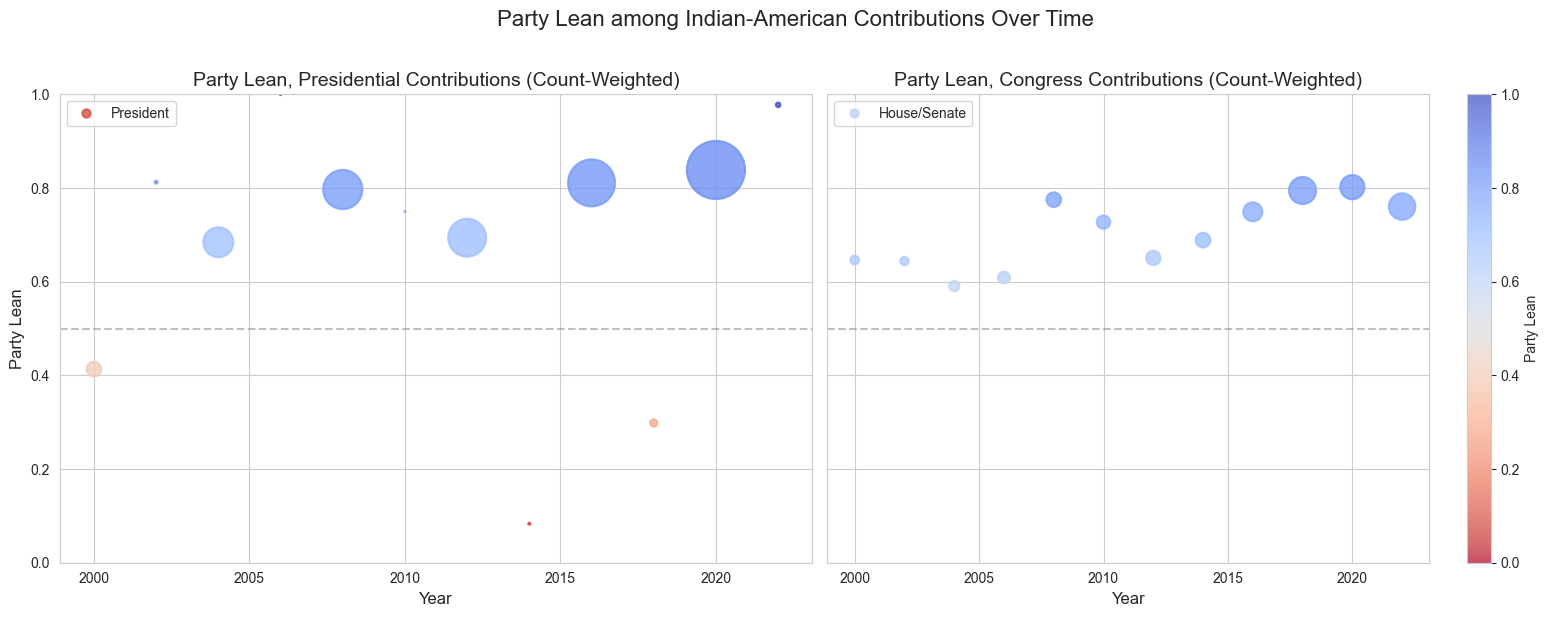

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)

sc1_pres = ax1.scatter(
    mean_pres_ind_by_year.index,
    mean_pres_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 5000,
    c=mean_pres_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='President',
    linewidths=1.5
)

ax1.set_title('Party Lean, Presidential Contributions (Count-Weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(sc1_pres.legend_elements()[0], ['President'], loc='upper left', fontsize=10)

sc2_cong = ax2.scatter(
    mean_congress_ind_by_year.index,
    mean_congress_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(['House', 'Senate']))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax2.set_title('Party Lean, Congress Contributions (Count-Weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(sc2_cong.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

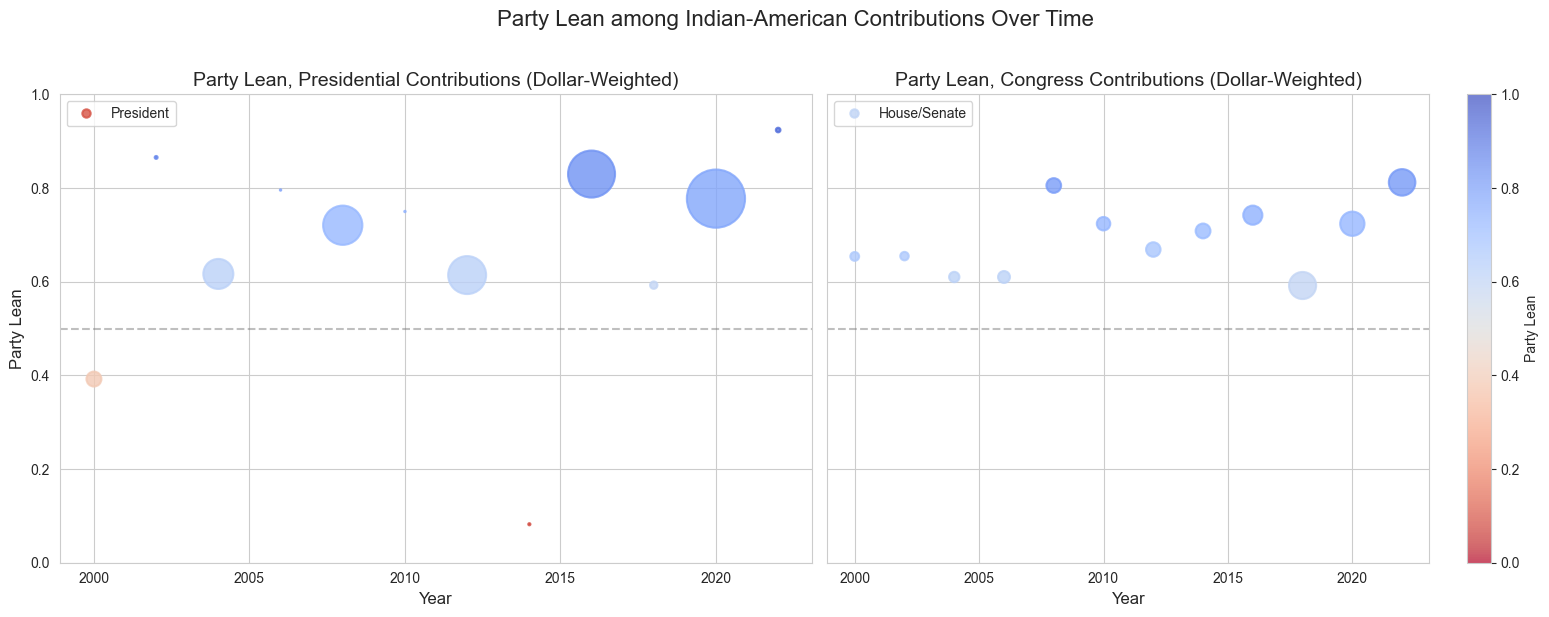

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)

sc1_pres = ax1.scatter(
    dollar_mean_pres_ind_by_year.index,
    dollar_mean_pres_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 5000,
    c=dollar_mean_pres_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='President',
    linewidths=1.5
)

ax1.set_title('Party Lean, Presidential Contributions (Dollar-Weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(sc1_pres.legend_elements()[0], ['President'], loc='upper left', fontsize=10)

sc2_cong = ax2.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(['House', 'Senate']))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax2.set_title('Party Lean, Congress Contributions (Dollar-Weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(sc2_cong.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

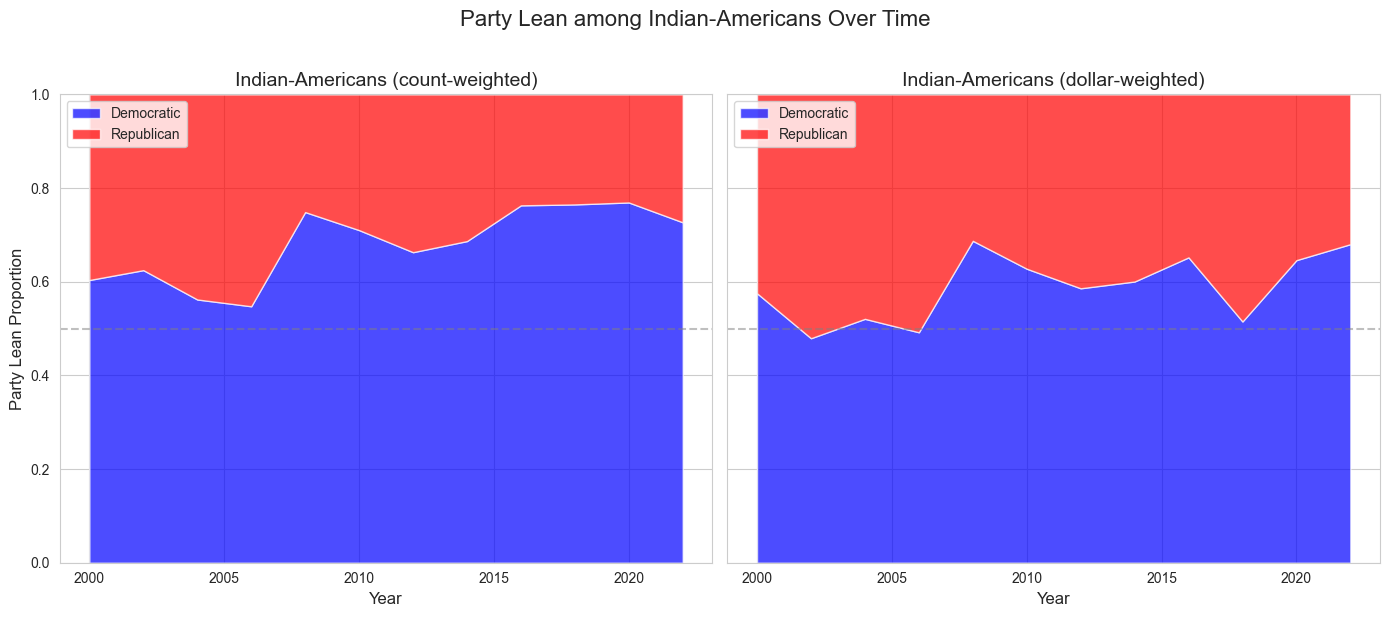

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sns.set_style("whitegrid")

# First subplot - Mean All (count-weighted)
plot_data1 = mean_ind_by_year.to_frame(name='dem_ratio')
plot_data1['rep_ratio'] = 1 - plot_data1['dem_ratio']

ax1.stackplot(plot_data1.index, 
             plot_data1['dem_ratio'], 
             plot_data1['rep_ratio'],
             colors=['blue', 'red'],
             alpha=0.7,
             labels=['Democratic', 'Republican'])
ax1.set_title('Indian-Americans (count-weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean Proportion', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(loc='upper left')

# Second subplot - Dollar Mean All (dollar-weighted)
plot_data2 = dollar_mean_ind_by_year.to_frame(name='dem_ratio')
plot_data2['rep_ratio'] = 1 - plot_data2['dem_ratio']

ax2.stackplot(plot_data2.index, 
             plot_data2['dem_ratio'], 
             plot_data2['rep_ratio'],
             colors=['blue', 'red'],
             alpha=0.7,
             labels=['Democratic', 'Republican'])
ax2.set_title('Indian-Americans (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(loc='upper left')

plt.suptitle('Party Lean among Indian-Americans Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

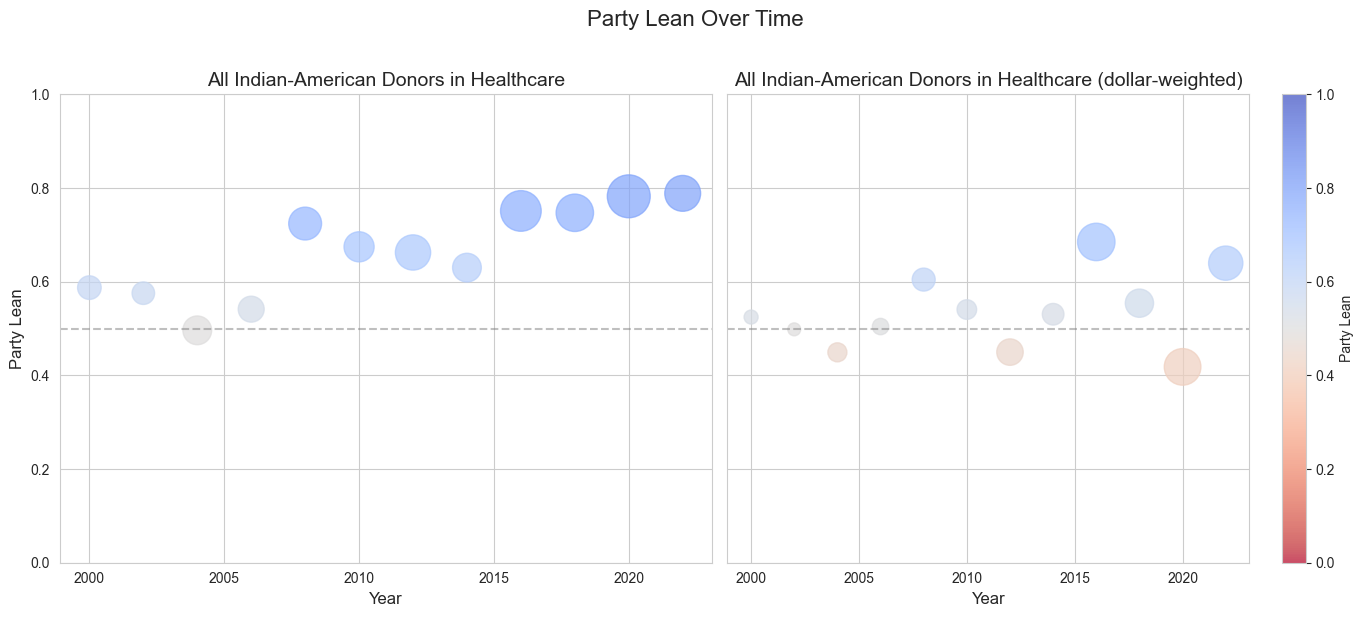

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/4,
    c=mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Healthcare', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Health"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Health")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/10000,
    c=dollar_mean_ind["Health"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Healthcare (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [6]:
dollar_mean_pres_ind_by_year = (
    all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

dollar_mean_congress_ind_by_year = (
    all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(['House', 'Senate']))]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [7]:
dollar_mean_pac_ind_by_year = (
    all_donors[(all_donors["ethnic"] == "ind") & (all_donors['recip_is_pac'] == True)]
    .drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"])
    .groupby(["cycle"])
    .apply(lambda x: (x["dem_ratio"] * x["total_donated"]).sum() / x["total_donated"].sum())
)

In [48]:
dollar_mean_pres_ind_by_year[2010] = 0.5
dollar_mean_pres_ind_by_year = dollar_mean_pres_ind_by_year.sort_index()
dollar_mean_pres_ind_by_year

cycle
2000    0.208347
2002    1.000000
2004    0.506401
2006    1.000000
2008    0.703050
2010    0.500000
2012    0.625013
2014    0.000000
2016    0.793939
2018    0.477208
2020    0.639884
2022    1.000000
dtype: float64

In [23]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == 'President')].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 5000

cycle
2000     115.4168
2002       4.4600
2004     467.7440
2006       0.9800
2008     799.4976
2010       0.9600
2012     747.8856
2014       2.4342
2016    1146.3274
2018      28.1582
2020    1756.5434
2022      11.1058
Name: total_donated, dtype: float64

In [24]:
all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(["House", "Senate"]))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 5000

cycle
2000     404.5546
2002     371.8160
2004     554.2602
2006     740.7780
2008    1118.6118
2010     940.0872
2012    1089.1360
2014    1139.6088
2016    1899.3466
2018    3816.2238
2020    3055.9974
2022    3651.3256
Name: total_donated, dtype: float64

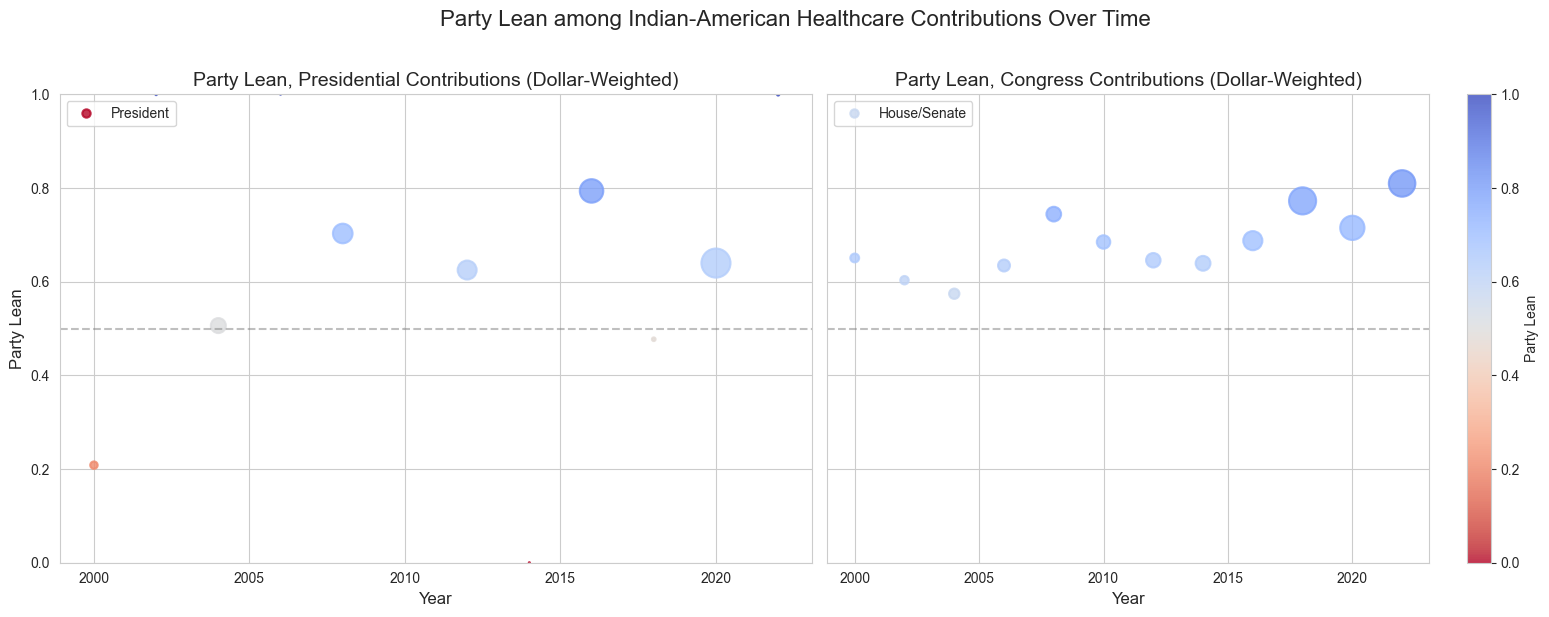

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)

sc1_pres = ax1.scatter(
    dollar_mean_pres_ind_by_year.index,
    dollar_mean_pres_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'] == "President")].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 20000,
    c=dollar_mean_pres_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='President',
    linewidths=1.5
)

ax1.set_title('Party Lean, Presidential Contributions (Dollar-Weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(sc1_pres.legend_elements()[0], ['President'], loc='upper left', fontsize=10)

sc2_cong = ax2.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(["House", "Senate"]))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax2.set_title('Party Lean, Congress Contributions (Dollar-Weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(sc2_cong.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2_cong, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Healthcare Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

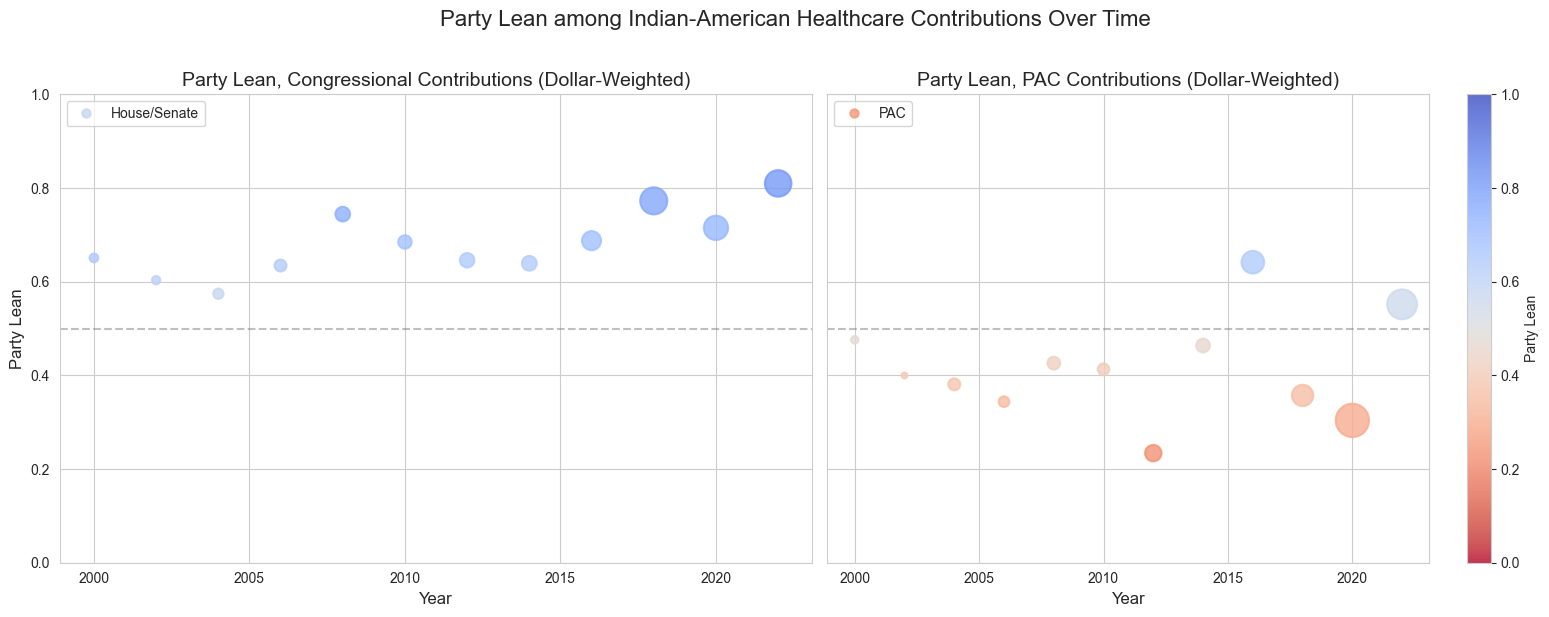

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)

sc1_pres = ax1.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(["House", "Senate"]))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax1.set_title('Party Lean, Congressional Contributions (Dollar-Weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(sc1_pres.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

sc2_cong = ax2.scatter(
    dollar_mean_pac_ind_by_year.index,
    dollar_mean_pac_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['recip_is_pac'] == True)].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_pac_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='PAC',
    linewidths=1.5
)

ax2.set_title('Party Lean, PAC Contributions (Dollar-Weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(sc2_cong.legend_elements()[0], ['PAC'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2_cong, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Healthcare Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

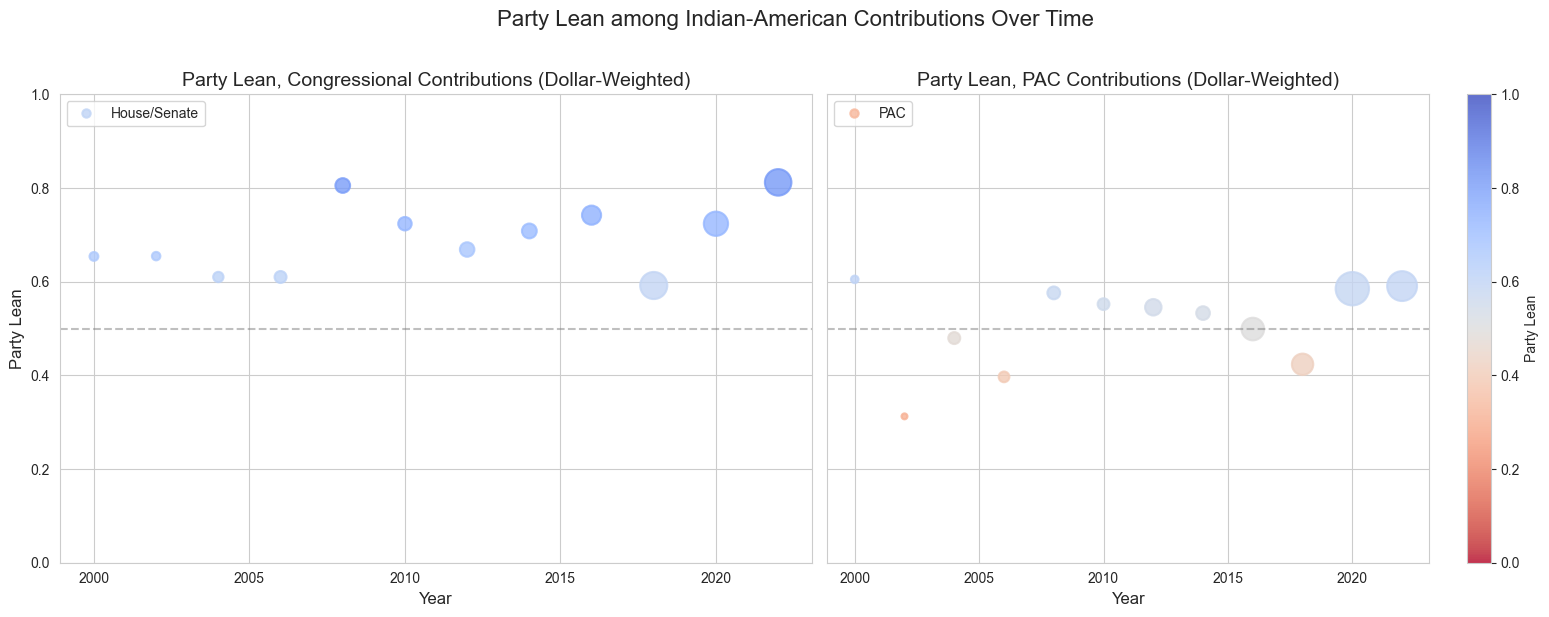

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)

sc1_pres = ax1.scatter(
    dollar_mean_congress_ind_by_year.index,
    dollar_mean_congress_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['level'].isin(["House", "Senate"]))].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_congress_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='House/Senate',
    linewidths=1.5
)

ax1.set_title('Party Lean, Congressional Contributions (Dollar-Weighted)', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax1.legend(sc1_pres.legend_elements()[0], ['House/Senate'], loc='upper left', fontsize=10)

sc2_cong = ax2.scatter(
    dollar_mean_pac_ind_by_year.index,
    dollar_mean_pac_ind_by_year,
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors['recip_is_pac'] == True)].drop_duplicates(subset=["cycle", "contrib_id"]).groupby(["cycle"])["total_donated"].sum() / 50000,
    c=dollar_mean_pac_ind_by_year,
    cmap=plt.cm.coolwarm_r,
    alpha=0.8,
    norm=norm1,
    label='PAC',
    linewidths=1.5
)

ax2.set_title('Party Lean, PAC Contributions (Dollar-Weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax2.legend(sc2_cong.legend_elements()[0], ['PAC'], loc='upper left', fontsize=10)

cbar2 = fig.colorbar(sc2_cong, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean among Indian-American Contributions Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

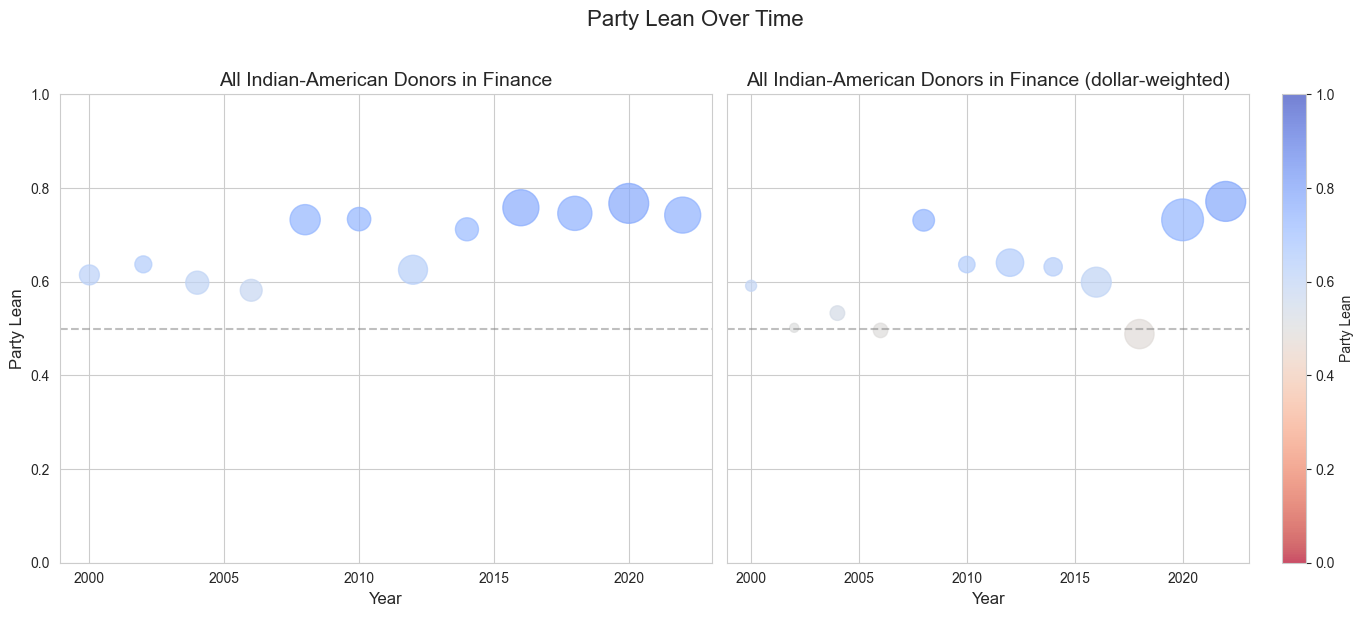

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Finance"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Finance")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Finance', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Finance"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Finance")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/10000,
    c=dollar_mean_ind["Finance"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Finance (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

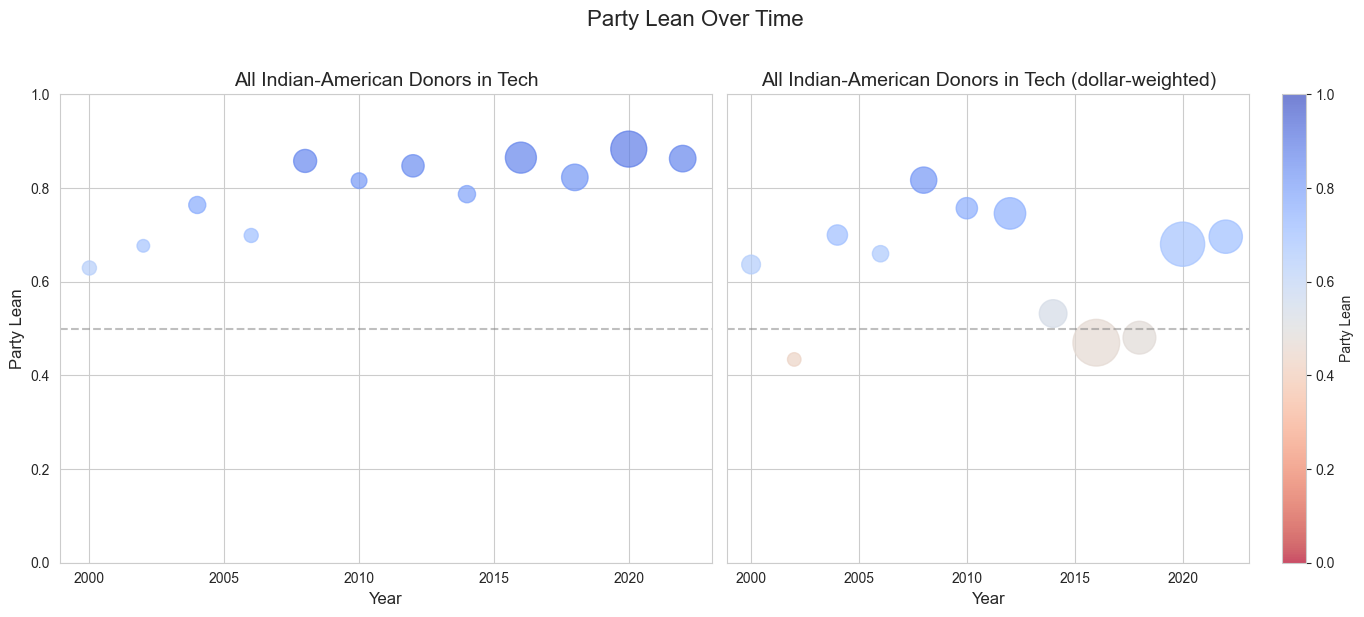

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Tech"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Tech")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Tech', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Tech"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Tech")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/3000,
    c=dollar_mean_ind["Tech"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Tech (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

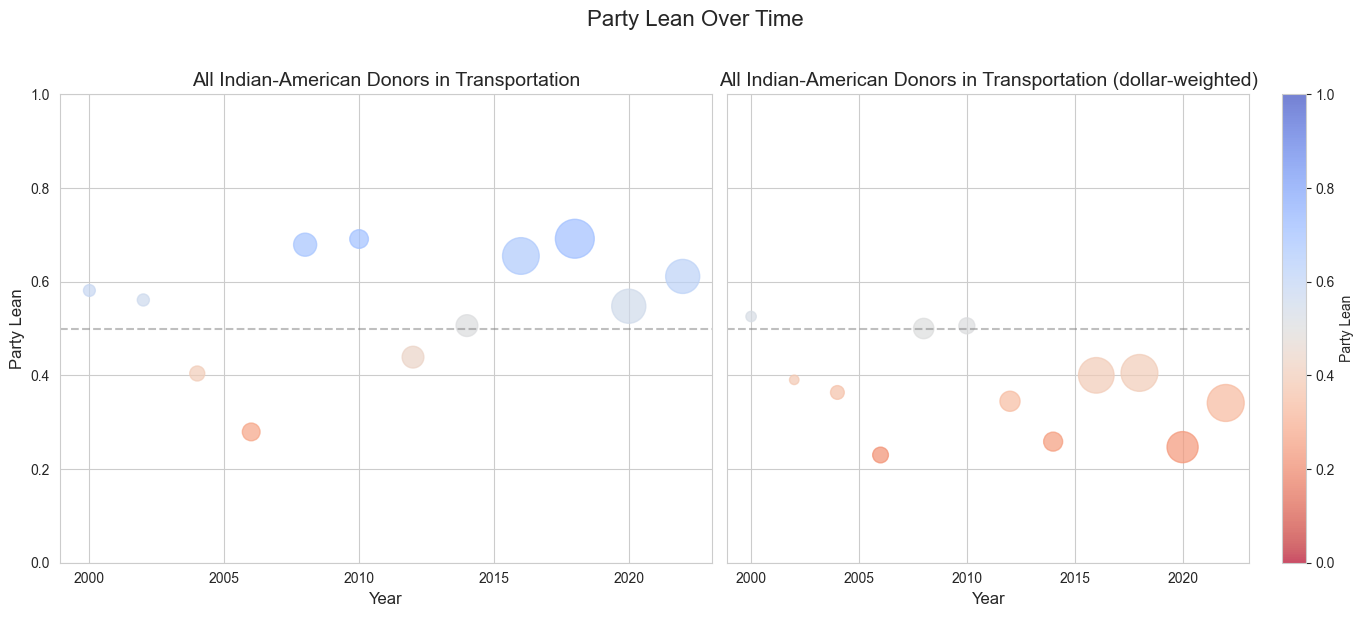

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.set_style("whitegrid")

norm1 = plt.Normalize(0, 1)
norm2 = plt.Normalize(0, 1)

sc1 = ax1.scatter(
    mean_ind.index,
    mean_ind["Transportation"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Transportation")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["contrib_id"].count()/2,
    c=mean_ind["Transportation"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax1.set_title('All Indian-American Donors in Transportation', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Party Lean', fontsize=12)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

sc2 = ax2.scatter(
    dollar_mean_ind.index,
    dollar_mean_ind["Transportation"],
    s=all_donors[(all_donors["ethnic"] == "ind") & (all_donors["sector"] == "Transportation")].drop_duplicates(subset=["cycle", "contrib_id", "dem_ratio"]).groupby(["cycle"])["total_donated"].sum()/3000,
    c=dollar_mean_ind["Transportation"],
    cmap=plt.cm.coolwarm_r,
    norm=norm1,
    alpha=0.7,
    label='Mean Party Lean'
)
ax2.set_title('All Indian-American Donors in Transportation (dollar-weighted)', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='gray', linestyle='--', alpha=0.5)

# Add legend and layout adjustments
cbar2 = fig.colorbar(sc2, ax=ax2, orientation='vertical', label='Party Lean')

plt.suptitle('Party Lean Over Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
all_donors.groupby(["cycle", "ethnic"])["contrib_id"].nunique()

cycle  ethnic
2000   ind          3762
       not        776971
2002   ind          3487
       not        651340
2004   ind          6050
       not       1123679
2006   ind          4843
       not        774840
2008   ind          8263
       not       1344202
2010   ind          5524
       not        814423
2012   ind          8539
       not       1268075
2014   ind          5560
       not        735563
2016   ind         14484
       not       2421656
2018   ind         13361
       not       1821195
2020   ind         21028
       not       3567909
2022   ind         15961
       not       2745057
Name: contrib_id, dtype: int64

In [ ]:
all_donors.groupby(["cycle", "ethnic", "sector"])["contrib_id"].nunique().reset_index()

,cycle,ethnic,sector,contrib_id
0,2000,ind,Agribusiness,26
1,2000,ind,Construction,150
2,2000,ind,Defense,12
3,2000,ind,Energy,56
4,2000,ind,Finance,377
...,...,...,...,...
331,2022,not,Manufacturing,21568
332,2022,not,Party,1150318
333,2022,not,Tech,71098
334,2022,not,Transportation,57563


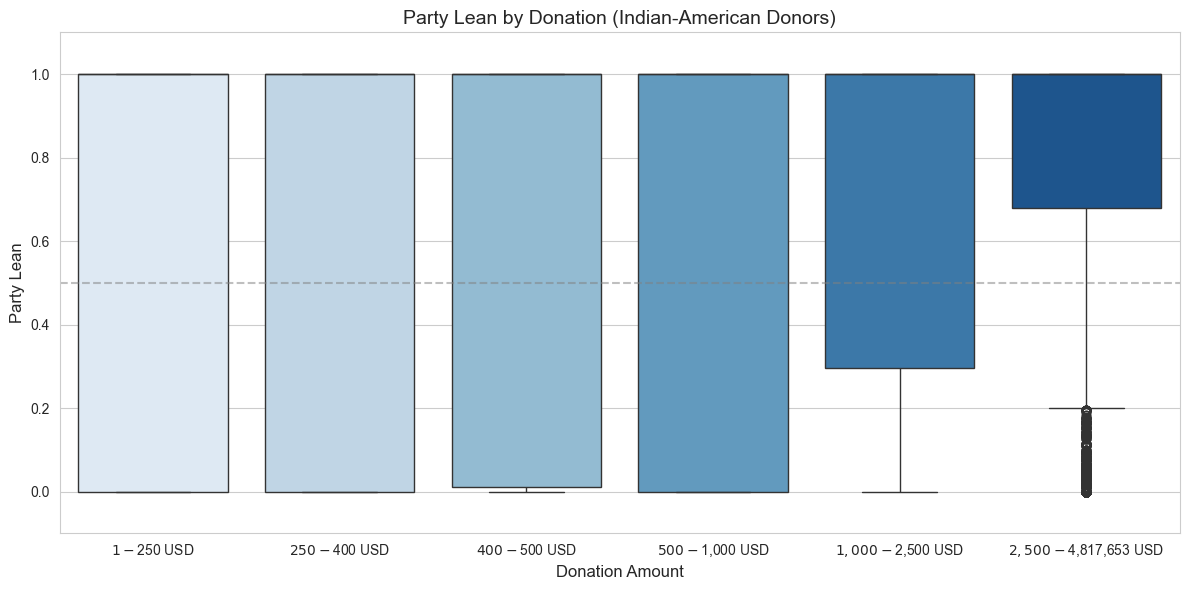

In [ ]:
all_donors["donation_bin"] = pd.qcut(
    all_donors[all_donors["ethnic"] == "ind"]["total_donated"],
    q=6,
    labels=False
)

bin_edges = pd.qcut(
    all_donors[all_donors["ethnic"] == "ind"]["total_donated"],
    q=6,
    retbins=True
)[1]
bin_labels = [f"${int(bin_edges[i]):,}-${int(bin_edges[i + 1]):,} USD" for i in range(len(bin_edges) - 1)]

sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=all_donors[all_donors["ethnic"] == "ind"],
    x="donation_bin",
    y="dem_ratio",
    palette="Blues"
)

plt.title("Party Lean by Donation (Indian-American Donors)", fontsize=14)
plt.xlabel("Donation Amount", fontsize=12)
plt.ylabel("Party Lean", fontsize=12)
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, fontsize=10)
plt.ylim(-0.1, 1.1)
plt.axhline(0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
grouped_stats = all_donors[all_donors["ethnic"] == "ind"].groupby("donation_bin")["dem_ratio"].agg(["mean", "median"])

# Add the bin labels for better readability
grouped_stats["donation_range"] = bin_labels

# Print the results
print(grouped_stats[["donation_range", "mean", "median"]])

                     donation_range      mean  median
donation_bin                                         
0.0                     $1-$250 USD  0.700559     1.0
1.0                   $250-$400 USD  0.678194     1.0
2.0                   $400-$500 USD  0.729620     1.0
3.0                 $500-$1,000 USD  0.722873     1.0
4.0               $1,000-$2,500 USD  0.734635     1.0
5.0           $2,500-$4,817,653 USD  0.758510     1.0


In [ ]:
# Group by donation_bin and calculate quartiles for dem_ratio
quartiles = all_donors[all_donors["ethnic"] == "ind"].groupby("donation_bin")["dem_ratio"].quantile([0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75]).unstack()

# Add the bin labels for better readability
quartiles["donation_range"] = bin_labels

# Rename columns for clarity
quartiles.columns = ["Range", "10th", "20th", "25th", "30th", "40th", "50th (Median)", "75th"]
quartiles

,Range,10th,20th,25th,30th,40th,50th (Median),75th
donation_bin,,,,,,,,
0.0,0.0,0.0,0.000000,0.500000,1.0,1.0,1.0,$1-$250 USD
1.0,0.0,0.0,0.000000,0.000000,1.0,1.0,1.0,$250-$400 USD
2.0,0.0,0.0,0.010941,1.000000,1.0,1.0,1.0,$400-$500 USD
3.0,0.0,0.0,0.000000,0.846154,1.0,1.0,1.0,"$500-$1,000 USD"
4.0,0.0,0.0,0.296774,0.931818,1.0,1.0,1.0,"$1,000-$2,500 USD"
5.0,0.0,0.0,0.678489,0.986188,1.0,1.0,1.0,"$2,500-$4,817,653 USD"
